In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [7]:
import os

# Keras functions
import tensorflow as tf
from tqdm import tqdm
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.layers import Dropout, LeakyReLU, BatchNormalization
from keras.layers import Activation, ZeroPadding2D, UpSampling2D
from keras.layers import Input, Reshape
from matplotlib import pyplot
from IPython.display import clear_output

# Numpy functions
import numpy
import numpy as np
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from numpy import zeros
from numpy import ones
from numpy import asarray

#Torchvision for fast and easy loading and resizing
import torchvision
import torchvision.transforms as transforms

from PIL import Image


In [8]:

WIDTH = 128
HEIGHT = 128
IMG_SIZE = (WIDTH,HEIGHT)
EPOCHS = 150

In [9]:
#for efficient data loading and manipulation, the images are save as binary file
#to reproduce the file the  code is below
#but if the saved file is already present the function will load it and not
#create it from scratch

dataset_path = "/content/drive/MyDrive/DCGAN_FOR_ART/resized"
saved_binary_file = "/content/drive/MyDrive/DCGAN_FOR_ART/training_data.npy"


def prepare_data(path_of_file , path_of_data):
    #Look for saved file to save time loading and processing images between runs
    print("Looking for saved binary file...")

    if not os.path.isfile(path_of_file):
        print("\n File not found, creating  new file...\n")
        dataset = []
        transform_ds = transforms.Compose([transforms.Resize(IMG_SIZE),]) #define transformation
        
        image_folder = torchvision.datasets.ImageFolder(root=path_of_data,
                                        transform=transform_ds)

        print('Number of artworks found: ',len(image_folder))
        
        
        print("Converting images, this will take a few minutes")
        for i in range (len(image_folder)):
            image_array = numpy.array(image_folder[i][0])
            dataset.append(image_array)
            if (i%500 == 0):
                print("Pictures processed: ", i)
                
        print("Saving dataset binary file...")
        dataset = np.array(dataset, dtype=np.float32)
        dataset = (dataset - 127.5) / 127.5 #Normalize to [-1 , 1]
        numpy.save(path_of_file, dataset)  #Save processed images as npy file

    else:
        print("Data found, loading..")
        dataset = np.load(path_of_file) 

    print("Dataset length: ", len(dataset))

    return dataset

dataset = prepare_data(saved_binary_file , dataset_path)

Looking for saved binary file...
Data found, loading..
Dataset length:  8683


In [10]:
#Using a TensorFlow Dataset to manage the images for easy shuffling, dividing etc
BATCH_SIZE = 32

training_dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(60000).batch(BATCH_SIZE)

In [11]:

import matplotlib.pyplot as plt
import random

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

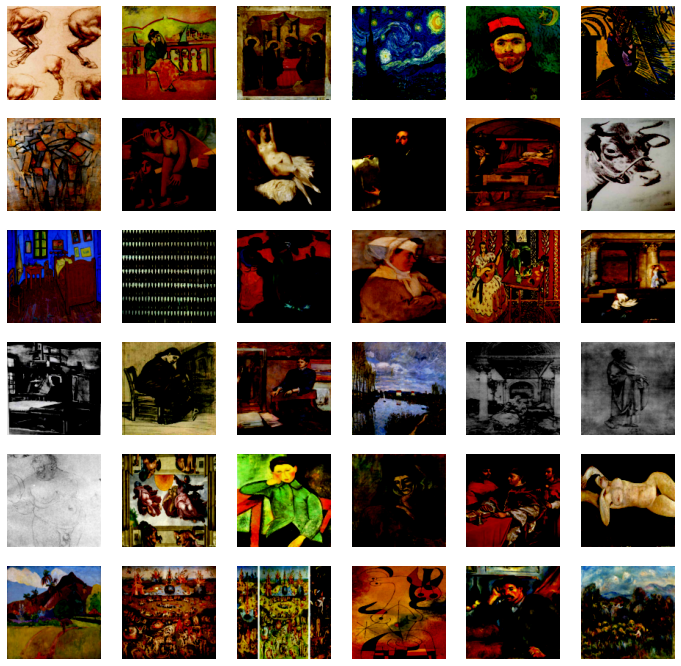

In [12]:

def visualize_random_art(dataset):
    """
    function to plot some random images from the data set 

    """
    np.random.shuffle(dataset) #Shuffle the images

    fig = plt.figure(figsize=(12,12))
    for i in range(1,37):
        fig.add_subplot(6,6,i)
        plt.imshow(dataset[i])
        plt.axis('off')

visualize_random_art(dataset)

In [15]:
def make_generator_model(seed_size, channels):
    """
    This function builds the generator for DCGAN 
    Parameters:
        seed_size:according to authors of DCGAN , Generator takes this random seed and generates an image
        channels : output channels that image will have
    """
    model = tf.keras.Sequential()
    
    model.add(Dense(4*4*512,activation="relu",input_dim=seed_size)) #64x64 units
    model.add(Reshape((4,4,512)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))

    model.add(Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dropout(0.4))

    model.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha =0.3))
    model.add(Dropout(0.4))
    
    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False  ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    
    model.add(Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False  ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    
    model.add(Conv2DTranspose(16, (5, 5), strides=(2, 2), padding='same', use_bias=False  ))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Conv2DTranspose(channels, (5, 5), strides=(1, 1), padding='same', use_bias=True, activation='tanh'))
 #   assert model.output_shape == (None, 64, 64, 3) , f"output shape mismatch {model.output_shape}"

    return model

In [16]:
SEED_SIZE = 100
IMAGE_CHANNELS = 3

generator = make_generator_model(SEED_SIZE ,IMAGE_CHANNELS)



In [17]:
def make_discriminator_model(image_shape):
    """
    This function builds a discriminator which is a CNN based image classifier
    and will output probability values of what it thinks is fake or real with  values close to
    0 being fake and 1 being real.

    Parameters :
        image_shape : input_image shape (h x w x c)
    """
    model = tf.keras.Sequential()
    model.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(128, 128, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(512, kernel_size=5, strides=2, padding='same'))
    model.add(BatchNormalization(momentum=0.9))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    return model

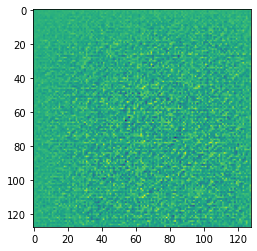

In [18]:
SEED_SIZE = 100
IMAGE_CHANNELS = 3

generator = make_generator_model(SEED_SIZE ,IMAGE_CHANNELS)
discriminator = make_discriminator_model([128,128,3])

noise = tf.random.normal([1,SEED_SIZE])

generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [19]:
image_shape = (HEIGHT, HEIGHT, IMAGE_CHANNELS)

discriminator = make_discriminator_model(image_shape)
print(discriminator(generated_image))


tf.Tensor([[0.49999684]], shape=(1, 1), dtype=float32)


In [20]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    """
    The discriminators loss is based on its ability to distinguish real images from fakes.
    It compares its predictions on real images to an array of ones (remember 1 being real)
    and its predictions on fake images to an array of zeros (0 being fake). 
    The goal is to classify all real images as 1 and all fakes as 0. 
    The total loss is then these two losses added together.

    Parameters : 
        real_output  : real image from the dataset 
        fake_output  : fake image from the dataset
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """
    The generators loss is a measurement of how good it performed at fooling the discriminator. 
    If the discriminator classifies the fake images as 1, the generator did a good job.

    Parameters :
     fake_output : fake image from generator
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)



In [21]:
#The two models optimizers are separated because we train them separately.
# I found a slightly lower generator LR to be beneficial.
#Beta value of 0.5 generates more stable models as per the findings in the paper 
#"Unsupervised representation learning with deep convolutional generative adversarial networks"

generator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4,0.5)

In [22]:
!mkdir ./training_checkpoints

In [23]:
#checkpoint for saving a model

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [24]:
def generate_images(generated_images2):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    generated_images2 =0.5 * generated_images2 + 0.5

    fig = plt.figure(figsize=(10,10))
    for i in range(1,21):
        fig.add_subplot(5,5,i)
        plt.imshow(generated_images2[i])
        plt.axis('off')

    plt.show()


In [25]:
EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [26]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    """
    The training begins by providing a random seed to the generator, which is then used to generate
    an image. The discriminator then classifies images from both the fake and real dataset.
    The loss is calculated separately for each model and the gradients are updated.

    Parameters  :
    images : images to be trained on
    """
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss , disc_loss ,generated_images

In [29]:
import matplotlib.pyplot as plt

cur_step = 0
generator_losses = []
discriminator_losses = []

def train(dataset, epochs):
  for epoch in range(epochs):
    gen_loss_list = []
    disc_loss_list = []
    start = time.time()

    for image_batch in tqdm(dataset):
        
        t =  train_step(image_batch)
        gen_loss_list.append(t[0])
        disc_loss_list.append(t[1])
    
    # Produce images for the GIF as you go
    # display.clear_output(wait=True)
    g_loss = sum(gen_loss_list) / len(gen_loss_list) #calculate losses
    d_loss = sum(disc_loss_list) / len(disc_loss_list)
    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
      generate_images(t[2])
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
    
    print(f'Epoch {epoch+1}, gen loss = {g_loss}, disc loss = {d_loss}')
    generator_losses.append(g_loss)
    discriminator_losses.append(d_loss)

    
  # Generate after the final epoch
  display.clear_output(wait=True)
  

In [30]:
train(training_dataset, EPOCHS) #run only for training

  0%|          | 0/272 [00:00<?, ?it/s]

Time for epoch 1 is 49.71688985824585 sec
Epoch 1, gen loss = 5.788963317871094, disc loss = 0.212148517370224


  0%|          | 0/272 [00:00<?, ?it/s]

Time for epoch 2 is 48.41249227523804 sec
Epoch 2, gen loss = 4.964496612548828, disc loss = 0.248687744140625


  0%|          | 0/272 [00:00<?, ?it/s]

Time for epoch 3 is 48.66475296020508 sec
Epoch 3, gen loss = 5.146529674530029, disc loss = 0.35545578598976135


  0%|          | 0/272 [00:00<?, ?it/s]

Time for epoch 4 is 48.571449279785156 sec
Epoch 4, gen loss = 4.344213962554932, disc loss = 0.3901733160018921


100%|██████████| 272/272 [00:48<00:00,  5.59it/s]

Time for epoch 5 is 48.69726204872131 sec
Epoch 5, gen loss = 4.151660919189453, disc loss = 0.45366454124450684


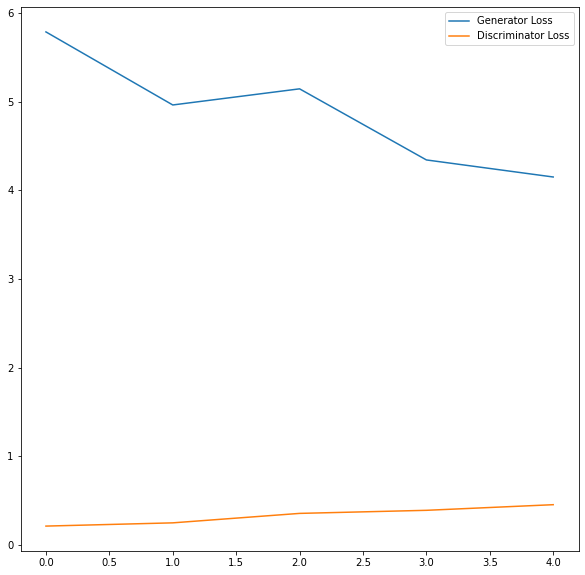

In [33]:
#code for visualizing losses

fig = plt.figure(figsize=(10,10))
plt.plot(
                range(EPOCHS) ,
                generator_losses,
                label="Generator Loss"
            )
plt.plot(
                range(EPOCHS) ,
                discriminator_losses,
                label="Discriminator Loss"
            )
plt.legend()

plt.show()


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))




In [ ]:
import keras
seed2 = tf.random.normal([1, 100])
generator = keras.models.load_model("./trained_generator.h5")

generated_images2 = generator(seed2, training = False)
generate_images(generated_images2)


In [ ]:

generate_images(generated_images2)

In [ ]:
generator = make_generator_model(SEED_SIZE ,IMAGE_CHANNELS)

In [ ]:
from keras.models import model_from_json
generator2 = generator.to_json()
with open("generator.json", "w") as json_file:
    json_file.write(generator2)
# serialize weights to HDF5
generator.save_weights("model.h5")
print("Saved model to disk")

In [ ]:
generator.save("trained_generator.h5")

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))